In [1]:
!bash push.sh

Already up to date.
[master a00eac6] Notebook updated.
 1 file changed, 758 insertions(+), 1476 deletions(-)
 rewrite TRAC-2.ipynb (60%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 11.80 KiB | 2.95 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/rachitsaksena/Multilingual-Agression-Classification
   38ddba7..a00eac6  master -> master


In [47]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

from googletrans import Translator
translator = Translator()
from spellchecker import SpellChecker
spellcheck = SpellChecker()

import spacy
nlp = spacy.load('en_core_web_sm')

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re
tokenizer = TweetTokenizer(preserve_case=True, strip_handles=True)

In [3]:
eng_train = pd.read_csv('Data/trac2_eng_train.csv')
eng_train.sample(5)

,ID,Text,Sub-task A,Sub-task B
1970,C10.235,Crap programme. Why not Arnab control the spea...,NAG,NGEN
521,C7.1000.1,Burnol?,NAG,NGEN
1749,C10.515,Was Arundhati Roy sleeping somewhere when NPR ...,NAG,NGEN
2855,C10.465,So finally RANGA is the real Indian and not Na...,NAG,NGEN
3436,C7.170,Liberals? Dude u embarrassed yourself in this ...,CAG,NGEN


In [4]:
eng_train.info() # no null enteries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4263 entries, 0 to 4262
Data columns (total 4 columns):
ID            4263 non-null object
Text          4263 non-null object
Sub-task A    4263 non-null object
Sub-task B    4263 non-null object
dtypes: object(4)
memory usage: 133.3+ KB


In [5]:
eng_train.iloc[28].Text, eng_train.iloc[28]['Sub-task A'] 

('feminism means equality not discrimination first you should learn about this\ngo and study about feminism.',
 'OAG')

In [6]:
eng_train[eng_train['Sub-task A'] == 'NAG'].sample(5)

,ID,Text,Sub-task A,Sub-task B
1064,C63.86.1,thank you,NAG,NGEN
891,C33.645,I am a lesbian and I am a proud of me and good...,NAG,NGEN
2354,C4.1880,Exactly what I felt about the movie!! 🔥,NAG,NGEN
1740,C33.355.2,i love u,NAG,NGEN
2954,C63.89,nice teps,NAG,NGEN


NAG    3375
CAG     453
OAG     435
Name: Sub-task A, dtype: int64

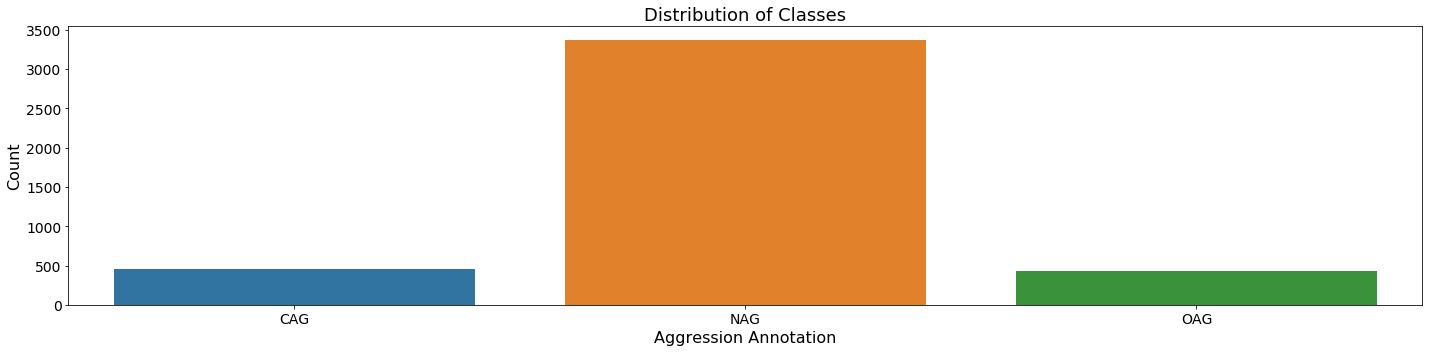

In [7]:
def barplot(df, x, y, title, label, ylabel, dim, orient = "v", ci = False, hue = None):
    
    plt.figure(figsize = dim, facecolor = "white")
    sns.barplot(x = x, y = y, data = df, orient = orient, ci = ci, hue = hue)
    plt.title(f"{title}", size = 18)
    plt.xlabel(f"{label}", size = 16)
    plt.ylabel(f"{ylabel}", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.tight_layout();
    

df = (eng_train.set_index(['ID', 'Sub-task A']).count(level='Sub-task A'))

barplot(df = df,
        x = df.index,
        y = "Text",
        title = "Distribution of Classes",
        label = "Aggression Annotation",
        ylabel = "Count",
        dim = (20,5))

eng_train['Sub-task A'].value_counts()

## CLEANING

In [8]:
def POS(df, attribute):
    total_tokens = []
    freq = {}
    for text in df[attribute]:
        doc = nlp(text)
        tokens = []
        for word in doc:
            pos = word.pos_
            if (pos in freq): 
                freq[pos] += 1
            else: 
                freq[pos] = 1
            tokens.append(pos)

        total_tokens.append(tokens)
    pos_df = pd.DataFrame({'POS': list(freq.keys()), 'Frequency':list(freq.values())})
    return pos_df

      POS  Frequency
0     ADJ       6094
1    NOUN      17789
2   SPACE       4237
3       X        714
4   PROPN       5613
5    PRON       5948
6   PUNCT       8710
7    VERB      14942
8    PART       1319
9     ADP       7175
10    DET       7297
11  CCONJ       2453
12    ADV       5643
13   INTJ        733
14    AUX        159
15    NUM        832
16    SYM        273

Part-of-speech tagging counts for combined corpus


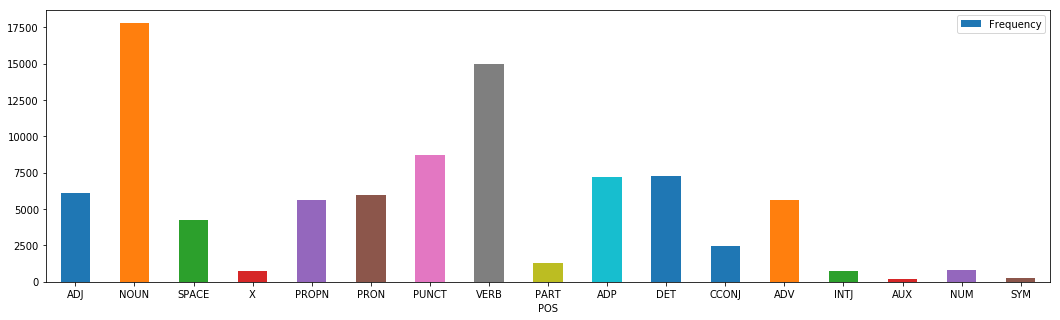

In [9]:
pos_df = POS(eng_train, 'Text')
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

In [33]:
def transliteration_list(df):
    propn = []
    for text in df['Text']:
        doc = nlp(text)
        for word in doc:
            pos = word.pos_
            if (pos == 'PROPN'): 
                propn.append(word.text)
            else: 
                continue
    return propn

In [34]:
propn = transliteration_list(eng_train)

In [12]:
def fetch_stopwords(url):
    stop = pd.read_csv(url, sep='\n', header=0, names=['words'])
    stop = stop['words'].values.tolist()
    return stop

In [13]:
# STOPWORDS

# from stopwordsiso import stopwords
# bangla_stopwords = stopwords('bn')

hinglish_stopwords = fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hinglish')
english_stopwords = set(stopwords.words('english') + hinglish_stopwords)
hindi_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hindi'))
bangla_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/rachitsaksena/Multilingual-Agression-Classification/master/bangla%20stop%2Ctxt'))

In [14]:
stop_dict = {'en': english_stopwords,
             'hi': hindi_stopwords,
             'bn': bangla_stopwords}

In [15]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F923"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [16]:
def tokenize_text(text):
    return tokenizer.tokenize(text)

In [21]:
def clean_text(df, lang):
    stop_words = stop_dict[lang]
    df['clean text'] = df['Text']
    for i in range(df.shape[0]):
        sentence = df['Text'].iloc[i]
        sentence = remove_emoji(sentence)
        sentence = re.sub(r"([.!?])", r"\1 ", sentence)
        sentence = re.sub(r'[/(){}\[\]\|@,;:.]', r'', str(sentence))
#         sentence = re.sub(r"[^a-z]+", r" ", sentence)
        sentence = ' '.join(word.lower() for word in sentence.split() if word not in stop_words and len(word)>2)
        df['clean text'].iloc[i] = sentence
    df["tokenized"] = [tokenize_text(text) for text in df['clean text']]
    return df

In [22]:
clean_text(eng_train, 'en')
eng_train.head()

,ID,Text,Sub-task A,Sub-task B,clean text,tokenized
0,C45.451,Next part,NAG,NGEN,next part,"[next, part]"
1,C47.11,Iii8mllllllm\nMdxfvb8o90lplppi0005,NAG,NGEN,iii8mllllllm mdxfvb8o90lplppi0005,"[iii, 8mllllllm, mdxfvb, 8o90lplppi0005]"
2,C33.79,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,NAG,NGEN,osm vedio make vedios,"[osm, vedio, make, vedios]"
3,C4.1961,What the fuck was this? I respect shwetabh and...,NAG,NGEN,what fuck this? respect shwetabh watching vide...,"[what, fuck, this, ?, respect, shwetabh, watch..."
4,C10.153,Concerned authorities should bring arundathi R...,NAG,NGEN,concerned authorities bring arundathi roy type...,"[concerned, authorities, bring, arundathi, roy..."


      POS  Frequency
0     ADJ       4904
1    NOUN      15490
2    VERB       6389
3    PRON        738
4     DET        684
5   PUNCT       1311
6    INTJ        305
7   CCONJ        263
8     ADV       1498
9   PROPN       4828
10   PART        202
11    NUM        361
12      X        233
13    ADP        293
14    AUX         28
15    SYM         66

Part-of-speech tagging counts for combined corpus


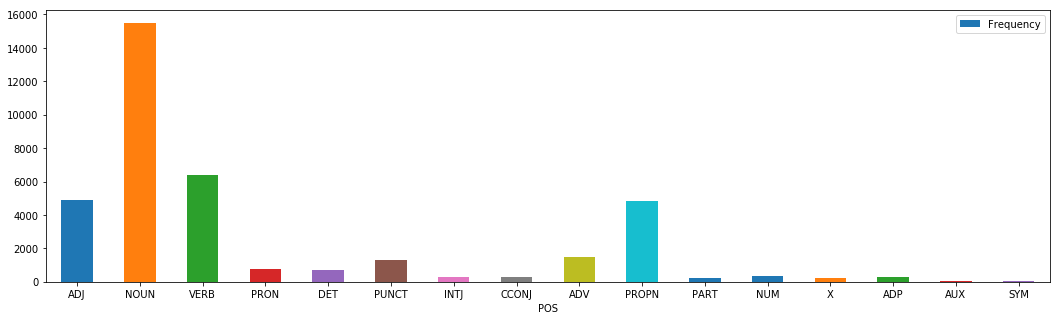

In [19]:
pos_df = POS(eng_train, 'clean text')
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

In [ ]:
# MOST FREQUENT STATS and CLEANING

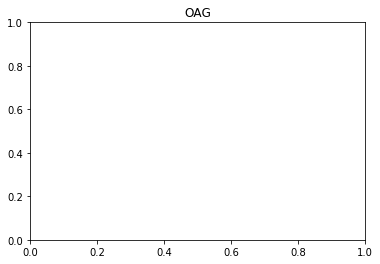

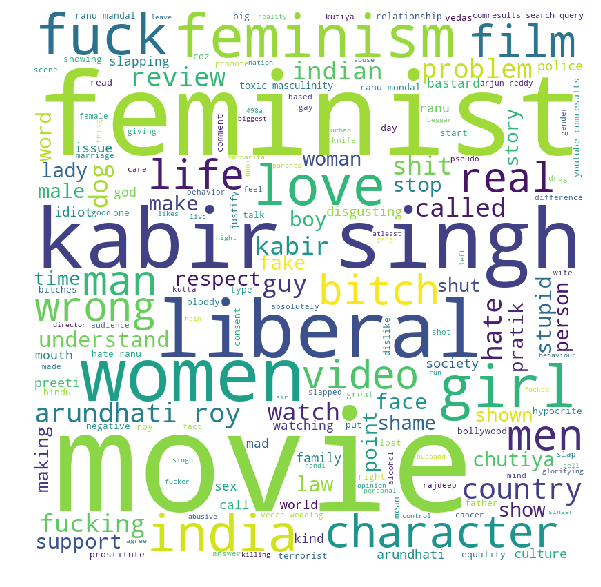

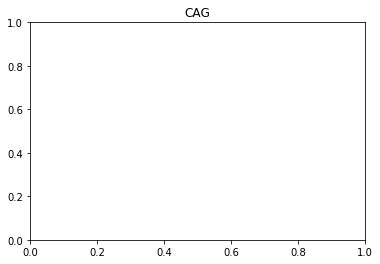

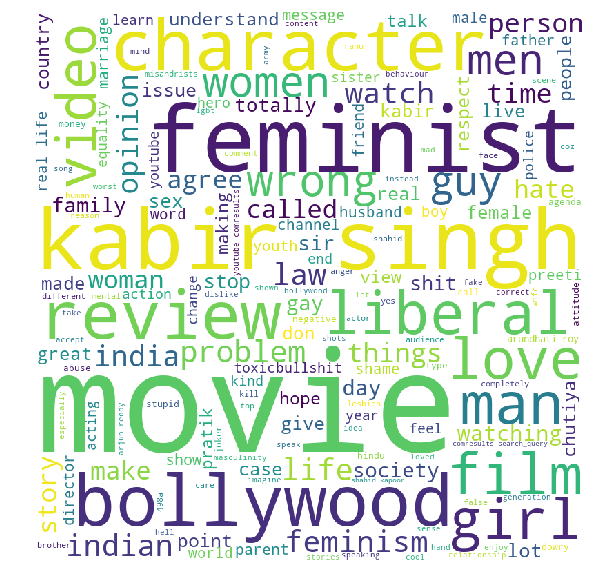

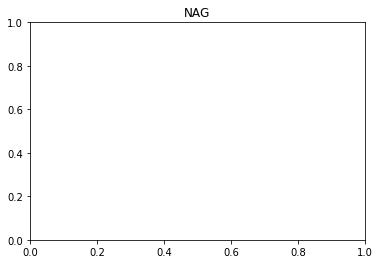

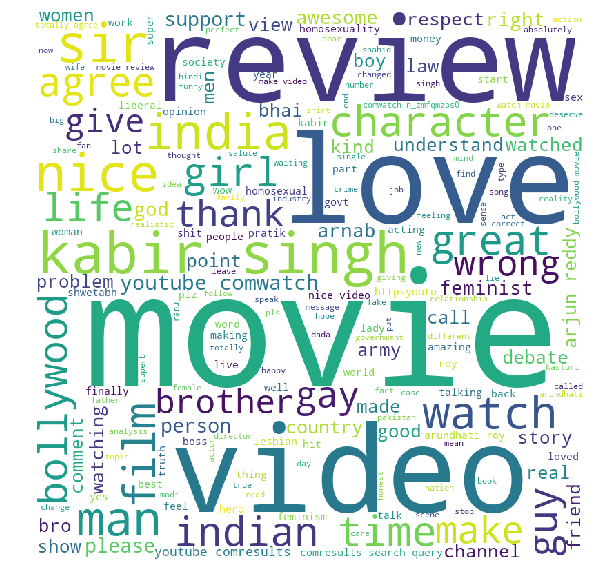

In [63]:
# WORD CLOUD
classes = {'NAG', 'CAG', 'OAG'}

for agg in classes:
    words = ''
    stopwords = set(STOPWORDS)

    for val in eng_train[eng_train["Sub-task A"]==agg]['clean text']: 
        tokens = str(val).split() 
        words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(words) 

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    print(agg)
    plt.show() 
    print("\n\n\n")

## LANGUAGE TAGGING

In [25]:
def script_tag(text):
    ben = re.compile("[" u"\U00000980-\U000009FF" "]+", flags=re.UNICODE) # Bengali
    hin = re.compile("[" u"\U00000900-\U0000097F" "]+", flags=re.UNICODE) # Hindi

    if ben.match(text):
        return 'bn'
    elif hin.match(text):
        return 'hi'
    else:
        return 'en'

In [57]:
def language_tag(df):
    df['final'] = df['clean text']
    for i in range(df.shape[0]):
        lis = []
        words = df['tokenized'].loc[i]
        for word in words:
            script = script_tag(word) 
            trans_script = translator.translate(word).src
            if(script == 'hi' or trans_script == 'hi'):
                lis.append(translator.translate(word, src='hi').text)
            elif(script == 'bn' or trans_script == 'bn'):
                lis.append(translator.translate(word, src='bn').text)
            elif(script == 'en' or trans_script == 'en'):
                if word in propn: #PROPN
                    lis.append(word)
                if len(spellcheck.unknown([word]))!=0: #SPELL CHECK
                    lis.append(spellcheck.correction(word))
                else:
                    lis.append(word)
        df['final'].loc[i] = lis
    return df

In [58]:
language_tag(eng_train.head())

/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/ramanshgrover/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Text,Sub-task A,Sub-task B,clean text,tokenized,final
0,C45.451,Next part,NAG,NGEN,next part,"[next, part]","[next, part]"
1,C47.11,Iii8mllllllm\nMdxfvb8o90lplppi0005,NAG,NGEN,iii8mllllllm mdxfvb8o90lplppi0005,"[iii, 8mllllllm, mdxfvb, 8o90lplppi0005]","[iii, 8mllllllm, mdxfvb, 8o90lplppi0005]"
2,C33.79,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,NAG,NGEN,osm vedio make vedios,"[osm, vedio, make, vedios]","[osf, vedic, make, videos]"
3,C4.1961,What the fuck was this? I respect shwetabh and...,NAG,NGEN,what fuck this? respect shwetabh watching vide...,"[what, fuck, this, ?, respect, shwetabh, watch...","[what, fuck, this, ?, respect, Whitish, watchi..."
4,C10.153,Concerned authorities should bring arundathi R...,NAG,NGEN,concerned authorities bring arundathi roy type...,"[concerned, authorities, bring, arundathi, roy...","[concerned, authorities, bring, arundathi, roy..."
